In [13]:
import numpy as np
import os
import wget
import tensorflow as tf
from training_utils import download_file, get_batches, read_and_decode_single_example, load_validation_data, \
    download_data, evaluate_model, get_training_data, load_weights, flatten
import matplotlib.pyplot as plt
%matplotlib inline
#import argparse
from tensorboard import summary as summary_lib

In [5]:
# arguments
epochs = 35
dataset = 6
init_model = None
how = "normal"
action = "train"

In [6]:
# download the data
download_data(what=dataset)
batch_size = 32
train_files, total_records = get_training_data(what=dataset)

In [7]:
## Hyperparameters
epsilon = 1e-8

# learning rate
epochs_per_decay = 5
starting_rate = 0.001
decay_factor = 0.80
staircase = True

# learning rate decay variables
steps_per_epoch = int(total_records / batch_size)
print("Steps per epoch:", steps_per_epoch)

# lambdas
lamC = 0.00010
lamF = 0.00200

# use dropout
dropout = True
fcdropout_rate = 0.5
convdropout_rate = 0.01
pooldropout_rate = 0.2

if how == "label":
    num_classes = 5
elif how == "normal":
    num_classes = 2
elif how == "mass":
    num_classes = 3
elif how == "benign":
    num_classes = 3

print("Number of classes:", num_classes)

Steps per epoch: 1961
Number of classes: 2


In [9]:
model_name = "model_s1.0.0.29g.5"
## Change Log
# 0.0.0.4 - increase pool3 to 3x3 with stride 3
# 0.0.0.6 - reduce pool 3 stride back to 2
# 0.0.0.7 - reduce lambda for l2 reg
# 0.0.0.8 - increase conv1 to 7x7 stride 2
# 0.0.0.9 - disable per image normalization
# 0.0.0.10 - commented out batch norm in conv layers, added conv4 and changed stride of convs to 1, increased FC lambda
# 0.0.0.11 - turn dropout for conv layers on
# 0.0.0.12 - added batch norm after pooling layers, increase pool dropout, decrease conv dropout, added extra conv layer to reduce data dimensionality
# 0.0.0.13 - added precision and f1 summaries
# 0.0.0.14 - fixing batch normalization, I don't think it's going to work after each pool
# 0.0.0.15 - reduced xentropy weighting term
# 0.0.0.17 - replaced initial 5x5 conv layers with 3 3x3 layers
# 0.0.0.18 - changed stride of first conv to 2 from 1
# 0.0.0.19 - doubled units in two fc layers
# 0.0.0.20 - lowered learning rate, put a batch norm back in
# 0.0.0.21 - put all batch norms back in
# 0.0.0.22 - increased lambdaC, removed dropout from conv layers
# 1.0.0.23 - added extra conv layers
# 1.0.0.27 - updates to training code and metrics
# 1.0.0.28 - using weighted x-entropy to improve recall
# 1.0.0.29 - updated code to work training to classify for multiple classes
# 1.0.0.29f - putting weighted x-entropy back
graph = tf.Graph()
with graph.as_default():
    training = tf.placeholder(dtype=tf.bool, name="is_training")
    is_testing = tf.placeholder(dtype=bool, shape=(), name="is_testing")

    # create global step for decaying learning rate
    global_step = tf.Variable(0, trainable=False)

    learning_rate = tf.train.exponential_decay(starting_rate,
                                               global_step,
                                               steps_per_epoch * epochs_per_decay,
                                               decay_factor,
                                               staircase=staircase)

    with tf.name_scope('inputs') as scope:
        image, label = read_and_decode_single_example(train_files, label_type=how, normalize=False)

        X_def, y_def = tf.train.shuffle_batch([image, label], batch_size=batch_size, capacity=2000,
                                              min_after_dequeue=1000)

        # Placeholders
        X = tf.placeholder_with_default(X_def, shape=[None, 299, 299, 1])
        y = tf.placeholder_with_default(y_def, shape=[None])

        X = tf.cast(X, dtype=tf.float32)

    # Convolutional layer 1
    with tf.name_scope('conv1') as scope:
        conv1 = tf.layers.conv2d(
            X,  # Input data
            filters=32,  # 32 filters
            kernel_size=(3, 3),  # Kernel size: 5x5
            strides=(2, 2),  # Stride: 2
            padding='SAME',  # "same" padding
            activation=None,  # None
            kernel_initializer=tf.truncated_normal_initializer(stddev=5e-2, seed=100),
            kernel_regularizer=tf.contrib.layers.l2_regularizer(scale=lamC),
            name='conv1'
        )

        conv1 = tf.layers.batch_normalization(
            conv1,
            axis=-1,
            momentum=0.99,
            epsilon=epsilon,
            center=True,
            scale=True,
            beta_initializer=tf.zeros_initializer(),
            gamma_initializer=tf.ones_initializer(),
            moving_mean_initializer=tf.zeros_initializer(),
            moving_variance_initializer=tf.ones_initializer(),
            training=training,
            name='bn1'
        )

        # apply relu
        conv1_bn_relu = tf.nn.relu(conv1, name='relu1')

    with tf.name_scope('conv1.1') as scope:
        conv11 = tf.layers.conv2d(
            conv1_bn_relu,  # Input data
            filters=32,  # 32 filters
            kernel_size=(3, 3),  # Kernel size: 5x5
            strides=(1, 1),  # Stride: 2
            padding='SAME',  # "same" padding
            activation=None,  # None
            kernel_initializer=tf.truncated_normal_initializer(stddev=5e-2, seed=101),
            kernel_regularizer=tf.contrib.layers.l2_regularizer(scale=lamC),
            name='conv1.1'
        )

        conv11 = tf.layers.batch_normalization(
            conv11,
            axis=-1,
            momentum=0.99,
            epsilon=epsilon,
            center=True,
            scale=True,
            beta_initializer=tf.zeros_initializer(),
            gamma_initializer=tf.ones_initializer(),
            moving_mean_initializer=tf.zeros_initializer(),
            moving_variance_initializer=tf.ones_initializer(),
            training=training,
            name='bn1.1'
        )

        # apply relu
        conv11 = tf.nn.relu(conv11, name='relu1.1')


    with tf.name_scope('conv1.2') as scope:
        conv12 = tf.layers.conv2d(
            conv11,  # Input data
            filters=32,  # 32 filters
            kernel_size=(3, 3),  # Kernel size: 5x5
            strides=(1, 1),  # Stride: 2
            padding='SAME',  # "same" padding
            activation=None,  # None
            kernel_initializer=tf.truncated_normal_initializer(stddev=5e-2, seed=1101),
            kernel_regularizer=tf.contrib.layers.l2_regularizer(scale=lamC),
            name='conv1.2'
        )

        conv12 = tf.layers.batch_normalization(
            conv12,
            axis=-1,
            momentum=0.99,
            epsilon=epsilon,
            center=True,
            scale=True,
            beta_initializer=tf.zeros_initializer(),
            gamma_initializer=tf.ones_initializer(),
            moving_mean_initializer=tf.zeros_initializer(),
            moving_variance_initializer=tf.ones_initializer(),
            training=training,
            name='bn1.2'
        )

        # apply relu
        conv12 = tf.nn.relu(conv12, name='relu1.1')

    # Max pooling layer 1
    with tf.name_scope('pool1') as scope:
        pool1 = tf.layers.max_pooling2d(
            conv12,  # Input
            pool_size=(3, 3),  # Pool size: 3x3
            strides=(2, 2),  # Stride: 2
            padding='SAME',  # "same" padding
            name='pool1'
        )

        # optional dropout
        if dropout:
            pool1 = tf.layers.dropout(pool1, rate=pooldropout_rate, seed=103, training=training)

    # Convolutional layer 2
    with tf.name_scope('conv2.1') as scope:
        conv2 = tf.layers.conv2d(
            pool1,
            filters=64,
            kernel_size=(3, 3),
            strides=(1, 1),
            padding='SAME',
            activation=None,  # None
            kernel_initializer=tf.truncated_normal_initializer(stddev=5e-2, seed=104),
            kernel_regularizer=tf.contrib.layers.l2_regularizer(scale=lamC),
            name='conv2.1'
        )

        conv2 = tf.layers.batch_normalization(
            conv2,
            axis=-1,
            momentum=0.99,
            epsilon=epsilon,
            center=True,
            scale=True,
            beta_initializer=tf.zeros_initializer(),
            gamma_initializer=tf.ones_initializer(),
            moving_mean_initializer=tf.zeros_initializer(),
            moving_variance_initializer=tf.ones_initializer(),
            training=training,
            name='bn2.1'
        )

        # apply relu
        conv2 = tf.nn.relu(conv2, name='relu2.1')

    with tf.name_scope('conv2.2') as scope:
        conv22 = tf.layers.conv2d(
            conv2,
            filters=64,
            kernel_size=(3, 3),
            strides=(1, 1),
            padding='SAME',
            activation=None,
            kernel_initializer=tf.truncated_normal_initializer(stddev=5e-2, seed=1104),
            kernel_regularizer=tf.contrib.layers.l2_regularizer(scale=lamC),
            name='conv2.2'
        )

        conv22 = tf.layers.batch_normalization(
            conv22,
            axis=-1,
            momentum=0.99,
            epsilon=epsilon,
            center=True,
            scale=True,
            beta_initializer=tf.zeros_initializer(),
            gamma_initializer=tf.ones_initializer(),
            moving_mean_initializer=tf.zeros_initializer(),
            moving_variance_initializer=tf.ones_initializer(),
            training=training,
            name='bn2.2'
        )

        # apply relu
        conv22 = tf.nn.relu(conv22, name='relu2.2')

    # Max pooling layer 2
    with tf.name_scope('pool2') as scope:
        pool2 = tf.layers.max_pooling2d(
            conv22,  # Input
            pool_size=(2, 2),  # Pool size: 2x2
            strides=(2, 2),  # Stride: 2
            padding='SAME',  # "same" padding
            name='pool2'
        )

        # optional dropout
        if dropout:
            pool2 = tf.layers.dropout(pool2, rate=pooldropout_rate, seed=106, training=training)

    # Convolutional layer 3
    with tf.name_scope('conv3.1') as scope:
        conv3 = tf.layers.conv2d(
            pool2,
            filters=128,
            kernel_size=(3, 3),
            strides=(1, 1),
            padding='SAME',
            activation=None,
            kernel_initializer=tf.truncated_normal_initializer(stddev=5e-2, seed=107),
            kernel_regularizer=tf.contrib.layers.l2_regularizer(scale=lamC),
            name='conv3.1'
        )

        conv3 = tf.layers.batch_normalization(
            conv3,
            axis=-1,
            momentum=0.99,
            epsilon=epsilon,
            center=True,
            scale=True,
            beta_initializer=tf.zeros_initializer(),
            gamma_initializer=tf.ones_initializer(),
            moving_mean_initializer=tf.zeros_initializer(),
            moving_variance_initializer=tf.ones_initializer(),
            training=training,
            name='bn3.1'
        )

        # apply relu
        conv3 = tf.nn.relu(conv3, name='relu3.1')

    with tf.name_scope('conv3.2') as scope:
        conv32 = tf.layers.conv2d(
            conv3,
            filters=128,
            kernel_size=(3, 3),
            strides=(1, 1),
            padding='SAME',
            activation=None,
            kernel_initializer=tf.truncated_normal_initializer(stddev=5e-2, seed=1107),
            kernel_regularizer=tf.contrib.layers.l2_regularizer(scale=lamC),
            name='conv3.2'
        )

        conv32 = tf.layers.batch_normalization(
            conv32,
            axis=-1,
            momentum=0.99,
            epsilon=epsilon,
            center=True,
            scale=True,
            beta_initializer=tf.zeros_initializer(),
            gamma_initializer=tf.ones_initializer(),
            moving_mean_initializer=tf.zeros_initializer(),
            moving_variance_initializer=tf.ones_initializer(),
            training=training,
            name='bn3.2'
        )

        # apply relu
        conv32 = tf.nn.relu(conv32, name='relu3.2')

    # Max pooling layer 3
    with tf.name_scope('pool3') as scope:
        pool3 = tf.layers.max_pooling2d(
            conv32,  # Input
            pool_size=(2, 2),  # Pool size: 2x2
            strides=(2, 2),  # Stride: 2
            padding='SAME',  # "same" padding
            name='pool3'
        )

        if dropout:
            pool3 = tf.layers.dropout(pool3, rate=pooldropout_rate, seed=109, training=training)

    # Convolutional layer 4
    with tf.name_scope('conv4') as scope:
            conv4 = tf.layers.conv2d(
                pool3,
                filters=256,
                kernel_size=(3, 3),
                strides=(1, 1),
                padding='SAME',
                activation=None,
                kernel_initializer=tf.truncated_normal_initializer(stddev=5e-2, seed=110),
                kernel_regularizer=tf.contrib.layers.l2_regularizer(scale=lamC),
                name='conv4'
            )

            conv4 = tf.layers.batch_normalization(
                conv4,
                axis=-1,
                momentum=0.99,
                epsilon=epsilon,
                center=True,
                scale=True,
                beta_initializer=tf.zeros_initializer(),
                gamma_initializer=tf.ones_initializer(),
                moving_mean_initializer=tf.zeros_initializer(),
                moving_variance_initializer=tf.ones_initializer(),
                training=training,
                name='bn4'
            )

            # apply relu
            conv4_bn_relu = tf.nn.relu(conv4, name='relu4')

    # Max pooling layer 4
    with tf.name_scope('pool4') as scope:
            pool4 = tf.layers.max_pooling2d(
                conv4_bn_relu,  # Input
                pool_size=(2, 2),  # Pool size: 2x2
                strides=(2, 2),  # Stride: 2
                padding='SAME',  # "same" padding
                name='pool4'
            )

            if dropout:
                pool4 = tf.layers.dropout(pool4, rate=pooldropout_rate, seed=112, training=training)

    # Convolutional layer 5
    with tf.name_scope('conv5') as scope:
        conv5 = tf.layers.conv2d(
            pool4,
            filters=512,
            kernel_size=(3, 3),
            strides=(1, 1),
            padding='SAME',
            activation=None,
            kernel_initializer=tf.truncated_normal_initializer(stddev=5e-2, seed=113),
            kernel_regularizer=tf.contrib.layers.l2_regularizer(scale=lamC),
            name='conv5'
        )

        conv5 = tf.layers.batch_normalization(
            conv5,
            axis=-1,
            momentum=0.99,
            epsilon=epsilon,
            center=True,
            scale=True,
            beta_initializer=tf.zeros_initializer(),
            gamma_initializer=tf.ones_initializer(),
            moving_mean_initializer=tf.zeros_initializer(),
            moving_variance_initializer=tf.ones_initializer(),
            training=training,
            name='bn5'
        )

        # apply relu
        conv5_bn_relu = tf.nn.relu(conv5, name='relu5')

    # Max pooling layer 4
    with tf.name_scope('pool5') as scope:
        pool5 = tf.layers.max_pooling2d(
            conv5_bn_relu,
            pool_size=(2, 2),  # Pool size: 2x2
            strides=(2, 2),  # Stride: 2
            padding='SAME',
            name='pool5'
        )

        if dropout:
            pool5 = tf.layers.dropout(pool5, rate=pooldropout_rate, seed=115, training=training)

    # Flatten output
    with tf.name_scope('flatten') as scope:
        flat_output = tf.contrib.layers.flatten(pool5)

        # global average pooling?
        # flat_output = tf.reduce_mean(pool5, axis=[1, 2])

        # dropout at fc rate
        flat_output = tf.layers.dropout(flat_output, rate=fcdropout_rate, seed=116, training=training)

    # Fully connected layer 1
    with tf.name_scope('fc1') as scope:
        fc1 = tf.layers.dense(
            flat_output,
            2048,
            activation=None,
            kernel_initializer=tf.variance_scaling_initializer(scale=2, seed=117),
            bias_initializer=tf.zeros_initializer(),
            kernel_regularizer=tf.contrib.layers.l2_regularizer(scale=lamF),
            name="fc1"
        )

        bn_fc1 = tf.layers.batch_normalization(
            fc1,
            axis=-1,
            momentum=0.9,
            epsilon=epsilon,
            center=True,
            scale=True,
            beta_initializer=tf.zeros_initializer(),
            gamma_initializer=tf.ones_initializer(),
            moving_mean_initializer=tf.zeros_initializer(),
            moving_variance_initializer=tf.ones_initializer(),
            training=training,
            name='bn_fc1'
        )

        fc1_relu = tf.nn.relu(bn_fc1, name='fc1_relu')

        # dropout
        fc1_relu = tf.layers.dropout(fc1_relu, rate=fcdropout_rate, seed=118, training=training)

    # Fully connected layer 2
    with tf.name_scope('fc2') as scope:
        fc2 = tf.layers.dense(
            fc1_relu,  # input
            2048,  # 2048 hidden units
            activation=None,  # None
            kernel_initializer=tf.variance_scaling_initializer(scale=2, seed=119),
            bias_initializer=tf.zeros_initializer(),
            kernel_regularizer=tf.contrib.layers.l2_regularizer(scale=lamF),
            name="fc2"
        )

        bn_fc2 = tf.layers.batch_normalization(
            fc2,
            axis=-1,
            momentum=0.9,
            epsilon=epsilon,
            center=True,
            scale=True,
            beta_initializer=tf.zeros_initializer(),
            gamma_initializer=tf.ones_initializer(),
            moving_mean_initializer=tf.zeros_initializer(),
            moving_variance_initializer=tf.ones_initializer(),
            training=training,
            name='bn_fc2'
        )

        fc2_relu = tf.nn.relu(bn_fc2, name='fc2_relu')

        # dropout
        fc2_relu = tf.layers.dropout(fc2_relu, rate=fcdropout_rate, seed=120, training=training)

    # Output layer
    logits = tf.layers.dense(
        fc2_relu,
        num_classes,      # One output unit per category
        activation=None,  # No activation function
        kernel_initializer=tf.variance_scaling_initializer(scale=1, seed=121),
        bias_initializer=tf.zeros_initializer(),
        name="logits"
    )

    with tf.variable_scope('conv1', reuse=True):
        conv_kernels1 = tf.get_variable('kernel')
        kernel_transposed = tf.transpose(conv_kernels1, [3, 0, 1, 2])

    with tf.variable_scope('visualization'):
        tf.summary.image('conv1/filters', kernel_transposed, max_outputs=32, collections=["kernels"])

    ## Loss function options
    # Regular mean cross entropy
    #mean_ce = tf.reduce_mean(tf.nn.sparse_softmax_cross_entropy_with_logits(labels=y, logits=logits))

    # This will weight the positive examples higher so as to improve recall
    weights = tf.multiply(1, tf.cast(tf.greater(y, 0), tf.int32)) + 1
    mean_ce = tf.reduce_mean(tf.losses.sparse_softmax_cross_entropy(labels=y, logits=logits, weights=weights))

    # Add in l2 loss
    loss = mean_ce + tf.losses.get_regularization_loss()

    # Adam optimizer
    optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate)

    # Minimize cross-entropy
    train_op = optimizer.minimize(loss, global_step=global_step)

    # get the probabilites for the classes
    probabilities = tf.nn.softmax(logits, name="probabilities")

    # Compute predictions from the probabilities
    predictions = tf.argmax(probabilities, axis=1, output_type=tf.int64)

    # get the accuracy
    accuracy, acc_op = tf.metrics.accuracy(
        labels=y,
        predictions=predictions,
        updates_collections=tf.GraphKeys.UPDATE_OPS,
        name="accuracy",
    )

    # calculate recall
    if num_classes > 2:
        # collapse the predictions down to normal or not for our pr metrics
        zero = tf.constant(0, dtype=tf.int64)
        collapsed_predictions = tf.cast(tf.greater(predictions, zero), tf.int64)
        collapsed_labels = tf.greater(y, zero)

        recall, rec_op = tf.metrics.recall(labels=collapsed_labels, predictions=collapsed_predictions, updates_collections=tf.GraphKeys.UPDATE_OPS, name="recall")
        precision, prec_op = tf.metrics.precision(labels=collapsed_labels, predictions=collapsed_predictions, updates_collections=tf.GraphKeys.UPDATE_OPS, name="precision")
        f1_score = 2 * ((precision * recall) / (precision + recall))

        tf.summary.scalar('recall_1', recall, collections=["summaries"])
        tf.summary.scalar('precision_1', precision, collections=["summaries"])
        tf.summary.scalar('f1_score', f1_score, collections=["summaries"])

        _, update_op = summary_lib.pr_curve_streaming_op(name='pr_curve',
                                                        predictions=(1 - probabilities[:, 0]),
                                                        labels=collapsed_labels,
                                                        updates_collections=tf.GraphKeys.UPDATE_OPS,
                                                        num_thresholds=20)
    else:
        recall, rec_op = tf.metrics.recall(labels=y, predictions=predictions, updates_collections=tf.GraphKeys.UPDATE_OPS, name="recall")
        precision, prec_op = tf.metrics.precision(labels=y, predictions=predictions, updates_collections=tf.GraphKeys.UPDATE_OPS, name="precision")
        f1_score = 2 * ( (precision * recall) / (precision + recall))

        _, update_op = summary_lib.pr_curve_streaming_op(name='pr_curve',
                                                         predictions=probabilities[:, 1],
                                                         labels=y,
                                                         updates_collections=tf.GraphKeys.UPDATE_OPS,
                                                         num_thresholds=20)

        tf.summary.scalar('recall_1', recall, collections=["summaries"])
        tf.summary.scalar('precision_1', precision, collections=["summaries"])
        tf.summary.scalar('f1_score', f1_score, collections=["summaries"])

    # Create summary hooks
    tf.summary.scalar('accuracy', accuracy, collections=["summaries"])
    tf.summary.scalar('cross_entropy', mean_ce, collections=["summaries"])
    tf.summary.scalar('learning_rate', learning_rate, collections=["summaries"])

    # add this so that the batch norm gets run
    extra_update_ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS)

    # Merge all the summaries
    merged = tf.summary.merge_all("summaries")
    kernel_summaries = tf.summary.merge_all("kernels")
    per_epoch_summaries = [[]]

    print("Graph created...")

Graph created...


In [6]:
## CONFIGURE OPTIONS
if init_model is not None:
    if os.path.exists(os.path.join("model", init_model + '.ckpt.index')):
        init = False
    else:
        init = True
else:
    if os.path.exists(os.path.join("model", model_name + '.ckpt.index')):
        init = False
    else:
        init = True

meta_data_every = 1
log_to_tensorboard = True
print_every = 5  # how often to print metrics
checkpoint_every = 1  # how often to save model in epochs
use_gpu = False  # whether or not to use the GPU
print_metrics = True  # whether to print or plot metrics, if False a plot will be created and updated every epoch

# Placeholders for metrics
train_cost_values = []
train_lr_values = []
train_acc_values = []
train_recall_values = []
valid_acc_values = []
valid_cost_values = []
valid_recall_values = []

config = tf.ConfigProto()

The model was trained on a Google Cloud instance with a GPU as it was far too computationally expensive to train on my laptop. Below is the code used to train it, the python scripts used are also in this repository. Metrics were logged to TensorBoard and the logs are included in this repository.

In [ ]:
## train the model
with tf.Session(graph=graph, config=config) as sess:
    if log_to_tensorboard:
        train_writer = tf.summary.FileWriter('./logs/tr_' + model_name, sess.graph)
        test_writer = tf.summary.FileWriter('./logs/te_' + model_name)

    if not print_metrics:
        # create a plot to be updated as model is trained
        f, ax = plt.subplots(1, 4, figsize=(24, 5))

    # create the saver
    saver = tf.train.Saver()

    # If the model is new initialize variables, else restore the session
    if init:
        sess.run(tf.global_variables_initializer())
        print("Initializing model...")
    else:
        # if we are initializing with the weights from another model load it
        if init_model is not None:
            # initialize the global variables
            sess.run(tf.global_variables_initializer())

            # create the initializer function to initialize the weights, excluding the layers we want to retrain
            init_fn = load_weights(init_model, exclude=["conv5", "bn5", "fc1", "bn_fc1", "bn_fc2", "fc3", "bn_fc3", "fc2", "fc_logits", "global_step"])

            # run the initializer
            init_fn(sess)

            # reset the global step
            initial_global_step = global_step.assign(0)
            sess.run(initial_global_step)

            print("Initializing weights from model", init_model)

            # reset init model so we don't do this again
            init_model = None
        # otherwise load this model
        else:
            saver.restore(sess, './model/' + model_name + '.ckpt')
            print("Restoring model", model_name)

    # if we are training the model
    if action == "train":
        coord = tf.train.Coordinator()
        threads = tf.train.start_queue_runners(coord=coord)

        print("Training model", model_name, "...")

        for epoch in range(epochs):
            sess.run(tf.local_variables_initializer())

            # Accuracy values (train) after each batch
            batch_acc = []
            batch_cost = []
            batch_recall = []

            for i in range(steps_per_epoch):
                # create the metadata
                run_options = tf.RunOptions(trace_level=tf.RunOptions.FULL_TRACE)
                run_metadata = tf.RunMetadata()

                # Run training op and update ops
                if (i % 50 != 0) or (i == 0):
                    # log the kernel images once per epoch
                    if (i == (steps_per_epoch - 1)) and log_to_tensorboard:
                        _, _, _, image_summary, step = sess.run(
                            [train_op, extra_update_ops, update_op, kernel_summaries, global_step],
                            feed_dict={
                                training: True,
                            },
                            options=run_options,
                            run_metadata=run_metadata)

                        # write the summary
                        train_writer.add_summary(image_summary, step)
                    else:
                        _, _, _, step = sess.run(
                            [train_op, extra_update_ops, update_op, global_step],
                                feed_dict={
                                    training: True,
                                },
                                options=run_options,
                                run_metadata=run_metadata)

                # every 50th step get the metrics
                else:
                    _, _, _, precision_value, summary, acc_value, cost_value, recall_value, step, lr = sess.run(
                        [train_op, extra_update_ops, update_op, prec_op, merged, accuracy, mean_ce, rec_op, global_step, learning_rate],
                        feed_dict={
                            training: True,
                        },
                        options=run_options,
                        run_metadata=run_metadata)

                    # Save accuracy (current batch)
                    batch_acc.append(acc_value)
                    batch_cost.append(cost_value)
                    batch_recall.append(recall_value)

                    # log the summaries to tensorboard every 50 steps
                    if log_to_tensorboard:
                        # write the summary
                        train_writer.add_summary(summary, step)

                # only log the meta data once per epoch
                if i == 1:
                    train_writer.add_run_metadata(run_metadata, 'step %d' % step)

            # save checkpoint every nth epoch
            if (epoch % checkpoint_every == 0):
                print("Saving checkpoint")
                save_path = saver.save(sess, './model/' + model_name + '.ckpt')

                # Now that model is saved set init to false so we reload it next time
                init = False

            # init batch arrays
            batch_cv_acc = []
            batch_cv_loss = []
            batch_cv_recall = []

            # initialize the local variables so we have metrics only on the evaluation
            sess.run(tf.local_variables_initializer())

            print("Evaluating model...")
            # load the test data
            X_cv, y_cv = load_validation_data(percentage=1, how=how, which=dataset)

            # evaluate the test data
            for X_batch, y_batch in get_batches(X_cv, y_cv, batch_size, distort=False):
                _, _, valid_acc, valid_recall, valid_precision, valid_fscore, valid_cost = sess.run(
                    [update_op, extra_update_ops, accuracy, rec_op, prec_op, f1_score, mean_ce],
                    feed_dict={
                        X: X_batch,
                        y: y_batch,
                        training: False
                    })

                batch_cv_acc.append(valid_acc)
                batch_cv_loss.append(valid_cost)
                batch_cv_recall.append(valid_recall)

            # Write average of validation data to summary logs
            if log_to_tensorboard:
                # evaluate once more to get the summary, which will then be written to tensorboard
                summary, cv_accuracy = sess.run(
                    [merged, accuracy],
                    feed_dict={
                        X: X_cv[0:2],
                        y: y_cv[0:2],
                        training: False
                    })

            test_writer.add_summary(summary, step)
            # test_writer.add_summary(other_summaries, step)
            step += 1

            # delete the test data to save memory
            del (X_cv)
            del (y_cv)

            print("Done evaluating...")

            # take the mean of the values to add to the metrics
            valid_acc_values.append(np.mean(batch_cv_acc))
            train_acc_values.append(np.mean(batch_acc))

            valid_cost_values.append(np.mean(batch_cv_loss))
            train_cost_values.append(np.mean(batch_cost))

            valid_recall_values.append(np.mean(batch_cv_recall))
            train_recall_values.append(np.mean(batch_recall))

            train_lr_values.append(lr)

            # save the metrics
            np.save(os.path.join("data", model_name + "train_acc.npy"), train_acc_values)
            np.save(os.path.join("data", model_name + "cv_acc.npy"), valid_acc_values)

            np.save(os.path.join("data", model_name + "train_loss.npy"), train_cost_values)
            np.save(os.path.join("data", model_name + "cv_loss.npy"), valid_cost_values)

            np.save(os.path.join("data", model_name + "train_recall.npy"), train_recall_values)
            np.save(os.path.join("data", model_name + "cv_recall.npy"), valid_recall_values)

            np.save(os.path.join("data", model_name + "train_lr.npy"), train_lr_values)

            # Print progress every nth epoch to keep output to reasonable amount
            if (epoch % print_every == 0):
                print(
                'Epoch {:02d} - step {} - cv acc: {:.4f} - train acc: {:.3f} (mean)'.format(
                    epoch, step, np.mean(batch_cv_acc), np.mean(batch_acc)
                ))

            # Print data every 50th epoch so I can write it down to compare models
            if (not print_metrics) and (epoch % 50 == 0) and (epoch > 1):
                if (epoch % print_every == 0):
                    print(
                    'Epoch {:02d} - step {} - cv acc: {:.4f} - train acc: {:.3f} (mean)'.format(
                        epoch, step, np.mean(batch_cv_acc), np.mean(batch_acc)
                    ))

        # stop the coordinator
        coord.request_stop()

        # Wait for threads to stop
        coord.join(threads)

## Training Results

The metrics created in training were saved to disk and are used here to plot the results of the training.

In [15]:
# load the data
train_acc_values = np.load(os.path.join("data", "results", model_name + "train_acc.npy"))
valid_acc_values = np.load(os.path.join("data", "results",model_name + "cv_acc.npy"))

train_cost_values = np.load(os.path.join("data", "results",model_name + "train_loss.npy"))
valid_cost_values = np.load(os.path.join("data", "results",model_name + "cv_loss.npy"))

train_recall_values = np.load(os.path.join("data", "results",model_name + "train_recall.npy"))
valid_recall_values = np.load(os.path.join("data", "results",model_name + "cv_recall.npy"))

train_lr_values = np.load(os.path.join("data", "results",model_name + "train_lr.npy"))

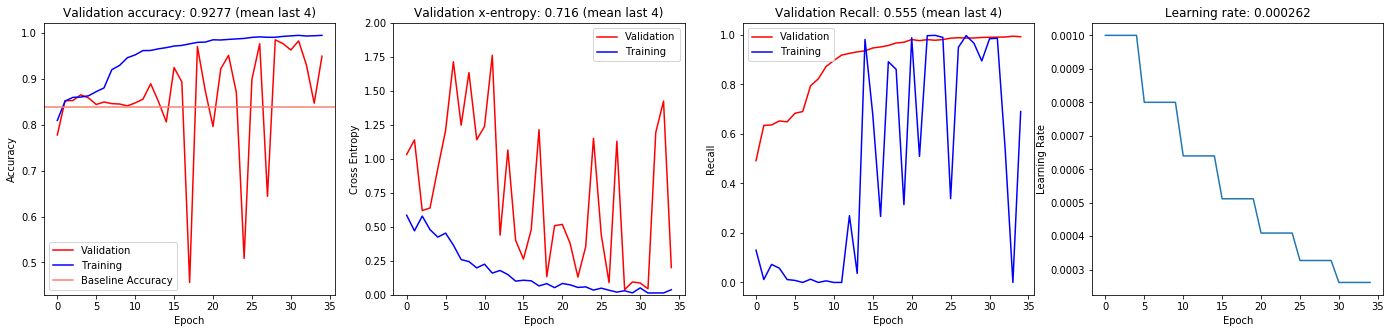

In [19]:
# initialize the plots
f, ax = plt.subplots(1, 4, figsize=(24, 5))

ax[0].plot(valid_acc_values, color="red", label="Validation")
ax[0].plot(train_acc_values, color="blue", label="Training")
ax[0].axhline(y=0.84, color="salmon", label="Baseline Accuracy")
ax[0].set_title('Validation accuracy: {:.4f} (mean last 4)'.format(np.mean(valid_acc_values[-4:])))
ax[0].set_xlabel('Epoch')
ax[0].set_ylabel('Accuracy')
ax[0].legend()

ax[1].plot(valid_cost_values, color="red", label="Validation")
ax[1].plot(train_cost_values, color="blue", label="Training")
ax[1].set_title('Validation x-entropy: {:.3f} (mean last 4)'.format(np.mean(valid_cost_values[-4:])))
ax[1].set_xlabel('Epoch')
ax[1].set_ylabel('Cross Entropy')
ax[1].set_ylim([0,2.0])
ax[1].legend()

ax[2].plot(train_recall_values, color="red", label="Validation")
ax[2].plot(valid_recall_values, color="blue", label="Training")
ax[2].set_title('Validation Recall: {:.3f} (mean last 4)'.format(np.mean(valid_recall_values[-4:])))
ax[2].set_xlabel('Epoch')
ax[2].set_ylabel('Recall')
ax[2].legend()

ax[3].plot(train_lr_values)
ax[3].set_title("Learning rate: {:.6f}".format(np.mean(train_lr_values[-1:])))
ax[3].set_xlabel("Epoch")
ax[3].set_ylabel("Learning Rate")

plt.show()

## Evaluate on Test Data

In [ ]:
## Evaluate on test data
with tf.Session(graph=graph, config=config) as sess:
    # create the saver
    saver = tf.train.Saver()
    
    # restore the model
    sess.run(tf.local_variables_initializer())
    saver.restore(sess, './model/' + model_name + '.ckpt')
    print("Restoring model", model_name)
    
    # load the test data
    X_te, y_te = load_validation_data(how=how, data="test", which=dataset)
    print("Evaluating on test data")
    
    test_accuracy = []
    test_recall = []
    test_predictions = []
    ground_truth = []
    for X_batch, y_batch in get_batches(X_te, y_te, batch_size, distort=False):
        _, yhat, test_acc_value, test_recall_value = sess.run([extra_update_ops, predictions, accuracy, rec_op], feed_dict=
        {
            X: X_batch,
            y: y_batch,
            training: False
        })

        test_accuracy.append(test_acc_value)
        test_recall.append(test_recall_value)
        test_predictions.append(yhat)
        ground_truth.append(y_batch)

    # print the results
    print("Mean Test Accuracy:", np.mean(test_accuracy))
    print("Mean Test Recall:", np.mean(test_recall))
    
    # unlist the predictions and truth
    test_predictions = flatten(test_predictions)
    ground_truth = flatten(ground_truth)
    
    # save the predictions and truth for review
    np.save(os.path.join("data", "predictions_" + model_name + ".npy"), test_predictions)
    np.save(os.path.join("data", "truth_" + model_name + ".npy"), ground_truth)
    
    ## Evaluate on MIAS Data
    X_te, y_te = load_validation_data(how=how, data="mias", which=dataset)

    mias_test_accuracy = []
    mias_test_recall = []
    mias_test_predictions = []
    mias_ground_truth = []
    for X_batch, y_batch in get_batches(X_te, y_te, batch_size, distort=False):
        _, yhat, test_acc_value, test_recall_value = sess.run([extra_update_ops, predictions, accuracy, rec_op], feed_dict=
        {
            X: X_batch,
            y: y_batch,
            training: False
        })

        mias_test_accuracy.append(test_acc_value)
        mias_test_recall.append(test_recall_value)
        mias_test_predictions.append(yhat)
        mias_ground_truth.append(y_batch)

    # print the results
    print("Mean MIAS Accuracy:", np.mean(mias_test_accuracy))
    print("Mean MIAS Recall:", np.mean(mias_test_recall))

    # unlist the predictions and truth
    mias_test_predictions = flatten(mias_test_predictions)
    mias_ground_truth = flatten(mias_ground_truth)

    # save the predictions and truth for review
    np.save(os.path.join("data", "mias_predictions_" + model_name + ".npy"), mias_test_predictions)
    np.save(os.path.join("data", "mias_truth_" + model_name + ".npy"), mias_ground_truth)